# Spontaneous parametric down conversion

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from main import *
import matplotlib.pyplot as plt
import numpy as np

In [15]:
# Define the central frequencies of the two downconverted modes and the pump
omega_s_0 = 1265832916458229.0  # signal mode central frequency
omega_i_0 = 1265832916458229.0  # idler mode central frequency
omega_p_0 = omega_s_0 + omega_i_0  # pump mode central frequency

# print(f"omega_s_0 = {omega_s_0}")
# print(f"omega_i_0 = {omega_i_0}")
# print(f"omega_p_0 = {omega_p_0}")

sel_y = Sellmeier(3.0065, 0.03901, 0.04547, 0.01408)
sel_z = Sellmeier(3.3134, 0.05694, 0.05658, 0.01692)

frequency_width = twopi * 2 * 1e12
ws_range = np.linspace(omega_s_0 - frequency_width / 2, omega_s_0 + frequency_width / 2, 1000)
wi_range = np.linspace(omega_i_0 - frequency_width / 2, omega_i_0 + frequency_width / 2, 1000)

dw_s = ws_range[1] - ws_range[0]
dw_i = wi_range[1] - wi_range[0]

WS_range, WI_range = np.meshgrid(ws_range, wi_range)


# define the phase-mismatch
def phase_mismatch(ws, wi):
    k_s = wave_number(sel_z, ws)
    k_i = wave_number(sel_y, wi)
    k_p = wave_number(sel_y, ws + wi)
    return k_s + k_i - k_p


#xaxis[:,None], yaxis[None,:]


#calculate phase-missmatch
delta_k = phase_mismatch(WS_range, WI_range)
delta_k_0 = phase_mismatch(omega_s_0, omega_i_0)

print(delta_k_0)

168634.40535869822


In [16]:
crystal_length = 2e-2  #crystal length in meters
phase_matching_function = np.sinc(
    crystal_length * (delta_k - delta_k_0) / 2 / np.pi)  # divide by pi because of numpy sinc definition

In [31]:
sigma = 5e11


def pump(ws, wi):
    return (1 / (sigma ** 2 * np.pi)) ** 0.25 * np.exp(-(ws + wi - omega_p_0) ** 2 / 2 / sigma ** 2)


PUMP = pump(ws_range[:, None], wi_range[None, :])

In [32]:
jsa = PUMP * phase_matching_function / np.sqrt(
    np.sum(np.abs(PUMP * phase_matching_function) ** 2) * dw_s * dw_i)


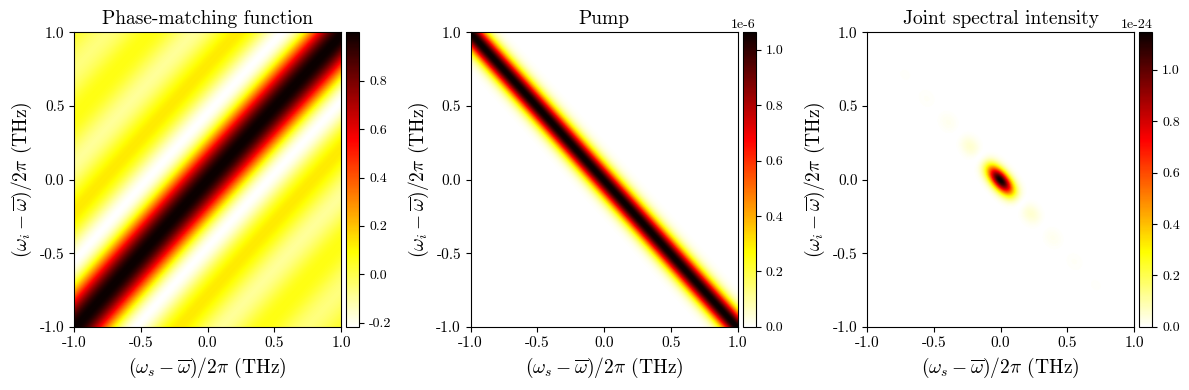

In [39]:
ticks_s = np.linspace(np.rint(np.min((ws_range - omega_s_0) * 1e-12 / twopi)),
                      np.rint(np.max((ws_range - omega_s_0) * 1e-12 / twopi)),
                      5)

ticks_i = np.linspace(np.rint(np.min((wi_range - omega_i_0) * 1e-12 / twopi)),
                      np.rint(np.max((wi_range - omega_i_0) * 1e-12 / twopi)),
                      5)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

im0 = ax[0].pcolormesh((WS_range - omega_s_0) * 1e-12 / twopi,
                       (WI_range - omega_i_0) * 1e-12 / twopi,
                       phase_matching_function,
                       shading='gouraud',
                       vmin=phase_matching_function.min(),
                       vmax=phase_matching_function.max(),
                       cmap='hot_r')
ax[0].set_xlabel(r"$(\omega_s - \overline{\omega})/2\pi$ (THz)", fontsize=fs)
ax[0].set_ylabel(r"$(\omega_i - \overline{\omega})/2\pi$ (THz)", fontsize=fs)
ax[0].set_title(r"Phase-matching function", fontsize=fs)
ax[0].tick_params(axis='both', labelsize=ts)
ax[0].set_yticks(ticks_s)
ax[0].set_xticks(ticks_i)

im1 = ax[1].pcolormesh((WS_range - omega_s_0) * 1e-12 / twopi,
                       (WI_range - omega_i_0) * 1e-12 / twopi,
                       PUMP,
                       shading='gouraud',
                       vmin=PUMP.min(),
                       vmax=PUMP.max(),
                       cmap='hot_r')
ax[1].set_xlabel(r"$(\omega_s - \overline{\omega})/2\pi$ (THz)", fontsize=fs)
ax[1].set_ylabel(r"$(\omega_i - \overline{\omega})/2\pi$ (THz)", fontsize=fs)
ax[1].set_title(r"Pump", fontsize=fs)
ax[1].tick_params(axis='both', labelsize=ts)
ax[1].set_yticks(ticks_s)
ax[1].set_xticks(ticks_i)

im2 = ax[2].pcolormesh((WS_range - omega_s_0) * 1e-12 / twopi,
                       (WI_range - omega_i_0) * 1e-12 / twopi,
                       np.abs(jsa) ** 2,
                       shading='gouraud',
                       vmin=(np.abs(jsa).min()) ** 2,
                       vmax=(np.abs(jsa).max()) ** 2,
                       cmap='hot_r')
ax[2].set_xlabel(r"$(\omega_s - \overline{\omega})/2\pi$ (THz)", fontsize=fs)
ax[2].set_ylabel(r"$(\omega_i - \overline{\omega})/2\pi$ (THz)", fontsize=fs)
ax[2].set_title(r"Joint spectral intensity", fontsize=fs)
ax[2].tick_params(axis='both', labelsize=ts)
ax[2].set_yticks(ticks_s)
ax[2].set_xticks(ticks_i)

plt.colorbar(im0, cax=make_axes_locatable(ax[0]).append_axes("right", size="5%", pad=0.05))
plt.colorbar(im1, cax=make_axes_locatable(ax[1]).append_axes("right", size="5%", pad=0.05))
plt.colorbar(im2, cax=make_axes_locatable(ax[2]).append_axes("right", size="5%", pad=0.05))

plt.tight_layout()
plt.show()

In [8]:
def coincidence(delay):
    phase = np.exp(-1j * (ws_range[None, :] - wi_range[:, None]) * delay)
    return 1 / 2 - 1 / 2 * np.sum(np.conj(jsa) * jsa.T * phase) * dw_s * dw_i


coincidence = np.vectorize(coincidence)

In [20]:
delay = np.linspace(-5e-12, 5e-12, 200)
coinc = np.real_if_close(coincidence(delay))

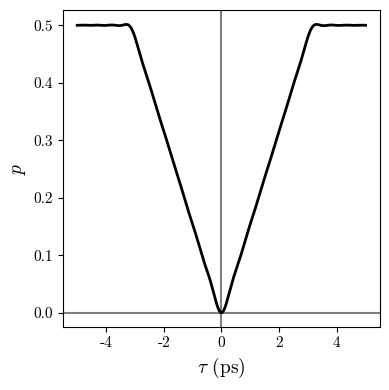

In [26]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.plot(delay * 1e12, coinc,
        linewidth=2,
        color='black')
ax.set_xlabel(r"$\tau$ (ps)", fontsize=fs)
ax.set_ylabel(r"$p$", fontsize=fs)
ax.tick_params(axis='both', labelsize=ts)
ax.axhline(0, color='black', alpha=0.5)
ax.axvline(0, color='black', alpha=0.5)

plt.tight_layout()
plt.show()

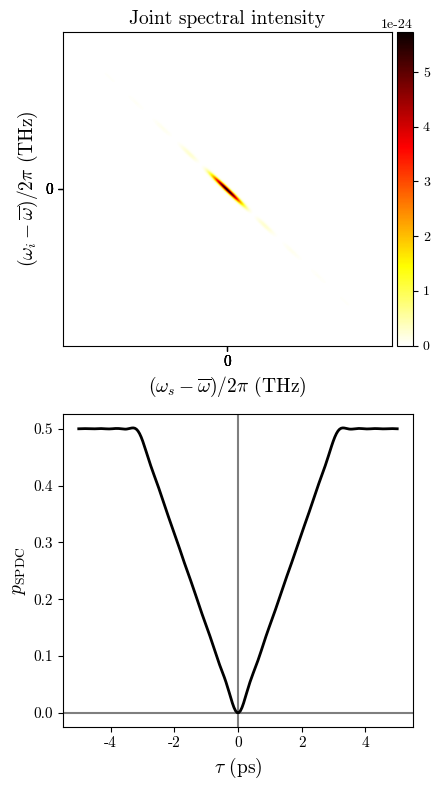

In [29]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(4.5, 8))
im0 = ax[0].pcolormesh((WS_range - omega_s_0) * 1e-12 / twopi,
                       (WI_range - omega_i_0) * 1e-12 / twopi,
                       np.abs(jsa) ** 2,
                       shading='gouraud',
                       vmin=(np.abs(jsa).min()) ** 2,
                       vmax=(np.abs(jsa).max()) ** 2,
                       cmap='hot_r')
ax[0].set_xlabel(r"$(\omega_s - \overline{\omega})/2\pi$ (THz)", fontsize=fs)
ax[0].set_ylabel(r"$(\omega_i - \overline{\omega})/2\pi$ (THz)", fontsize=fs)
ax[0].set_title(r"Joint spectral intensity", fontsize=fs)
ax[0].tick_params(axis='both', labelsize=ts)
ax[0].set_yticks(ticks_s)
ax[0].set_xticks(ticks_i)

plt.colorbar(im0, cax=make_axes_locatable(ax[0]).append_axes("right", size="5%", pad=0.05))

ax[1].plot(delay * 1e12, coinc,
           linewidth=2,
           color='black')
ax[1].set_xlabel(r"$\tau$ (ps)", fontsize=fs)
ax[1].set_ylabel(r"$p_\mathrm{SPDC}$", fontsize=fs)
ax[1].tick_params(axis='both', labelsize=ts)
ax[1].axhline(0, color='black', alpha=0.5)
ax[1].axvline(0, color='black', alpha=0.5)

plt.tight_layout()
fig.savefig('figures/fig4.png', dpi=300, bbox_inches='tight')
plt.show()